# Two - Tower Retreival Model

### Key resources:
* Many pages [here](https://www.tensorflow.org/recommenders/examples/deep_recommenders) include great techniques to build custom TFRS Models

### GOALs:
* Demonstrate how to leverage shared tfrs files, creating optimal training pipelines
* Show how to model off of most data types 
  * (String, Existing Embeddings (vectors), 
  * Floats (Normalized), 
  * Categorical with vocab, 
  * High Dim Categorical (Embed)
* Leverage class templates to create custom 2 Tower Models quick/easy

In [1]:
from google.cloud import storage

client = storage.Client()
files = []
for blob in client.list_blobs('tfrs-tf-records'):
    files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
    
    
files_cat = []
for blob in client.list_blobs('prod-catalog-central'):
    files_cat.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
    
print(files_cat[:2])

['gs://prod-catalog-central/file_00-36683.tfrec', 'gs://prod-catalog-central/file_01-36684.tfrec']


## Datprep, Pipeline Start, and Params

In [5]:
import json
import tensorflow as tf
import tensorflow_recommenders as tfrs


def parse_tfrecord_fn(example):
    feature_description = {
         #query features
        "query": tf.io.FixedLenFeature([1], tf.string),
        "last_viewed": tf.io.FixedLenFeature([1], tf.string),

        #candidate features
        "IVM_s": tf.io.FixedLenFeature([1], tf.string),
        "description": tf.io.FixedLenFeature([1], tf.string),
        "price_td": tf.io.FixedLenFeature([1], tf.float32),
        "PriceRange_s": tf.io.FixedLenFeature([1],  tf.string),
        "productTypeCombo_ss": tf.io.FixedLenFeature([1], tf.string),
        "visual": tf.io.FixedLenFeature([2048,], tf.float32),
        "month": tf.io.FixedLenFeature([1], tf.string),
        "hour": tf.io.FixedLenFeature([1], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example


def parse_tfrecord_catalog(example):
    feature_description = {
        #candidate features
        "IVM_s": tf.io.FixedLenFeature([1], tf.string),
        "description": tf.io.FixedLenFeature([1], tf.string),
        "price_td": tf.io.FixedLenFeature([1], tf.float32),
        "PriceRange_s": tf.io.FixedLenFeature([1],  tf.string),
        "productTypeCombo_ss": tf.io.FixedLenFeature([1], tf.string)#,
         #"visual": tf.io.FixedLenFeature([2048,], tf.float32)
    }
    example = tf.io.parse_single_example(example, feature_description)
    return example

# 'The number of uniques for IVM_s are: 212861'
# 'The number of uniques for productTypeCombo_ss are: 212861'

EMBEDDING_DIM = 64
MAX_TOKENS = 500_000 #1265634
N_PRODUCTS = 40_000 #212_862 212861
N_HEIR = 20_000 #54724 
BATCH_SIZE = 2048
ARCH = [256, 128, 64]
NUM_EPOCHS = 30
NUM_RECORDS = 4_293_302 #sum(1 for _ in file_io.FileIO(SMALL_DATASET, 'rb')) #CHANGE THIS TO LARGE DATASET WHEN READY
TEST_PCT = 0.05
print(f'Batches per epoch: {NUM_RECORDS/BATCH_SIZE}')

TF_RECORDS_DIR = 'gs://tfrs-central-a'

# Set dev dataset CHANGE THIS LATER TO THE WHOLE DIR
#TRAINING WHEELS
raw_dataset = tf.data.TFRecordDataset(files) #local machine training wheels - using smaller data set for starters
cat_dataset = tf.data.TFRecordDataset(files_cat)


#See `pipeline-opts.ipynb` for more info on tuning options
parsed_dataset = raw_dataset.map(
        parse_tfrecord_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )


# Doing another pipeline for the adapts to get startup to run much faster

parsed_dataset_adapt = raw_dataset.map(
    parse_tfrecord_fn,
    num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )

parsed_dataset_adapt = parsed_dataset_adapt.batch(BATCH_SIZE)

# parsed_dataset_adapt = parsed_dataset_adapt.batch(BATCH_SIZE)
# loading de-duplicated product catalog

parsed_dataset_candidates = cat_dataset.map(
        parse_tfrecord_catalog,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )

parsed_dataset_candidates = parsed_dataset_candidates.cache()

Batches per epoch: 2096.3388671875


## Query Model
Takes: 
* timestamp components `hour`, `month`
* user search query
* last n viewed (n <= 3)

In [6]:
class QueryModel(tf.keras.Model):
    
    def __init__(self, layer_sizes):
        super().__init__()
        
        month_vocab = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
        hour_vocab = month_vocab + ["13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "00"]

        self.month_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=month_vocab, mask_token=None, name="month_lookup"),
            tf.keras.layers.Embedding(
                len(month_vocab)+1, EMBEDDING_DIM, mask_zero=True, name="month_emb"),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        
        self.hour_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=hour_vocab, mask_token=None, name="hour_lookup"),
            tf.keras.layers.Embedding(len(hour_vocab)+1, EMBEDDING_DIM, mask_zero=True, name="hour_emb"),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
    
        self.query_vectorizor = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=MAX_TOKENS, name="query_tv")
        
        self.last_viewed_vectorizor = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=MAX_TOKENS, name="last_viewed_tv")
        
        self.query_embedding = tf.keras.Sequential([
            self.query_vectorizor,
            tf.keras.layers.Embedding(MAX_TOKENS, EMBEDDING_DIM , mask_zero=True, name="query_emb"),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        
        self.last_viewed_embedding = tf.keras.Sequential([
            self.last_viewed_vectorizor,
            tf.keras.layers.Embedding(MAX_TOKENS, EMBEDDING_DIM , mask_zero=True, name="last_v_emb"),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        
        ### adapt stuff
        self.query_vectorizor.adapt(parsed_dataset_adapt.map(lambda x: x['query']))
        self.last_viewed_vectorizor.adapt(parsed_dataset_adapt.map(lambda x: x['last_viewed'])) 
        
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))


    def call(self, data):    
        all_embs = tf.concat(
                [
                    self.month_embedding(data['month']),
                    self.hour_embedding(data['hour']),
                    self.query_embedding(data['query']),
                    self.last_viewed_embedding(data['last_viewed'])
                ], axis=1)
        return self.dense_layers(all_embs)

In [7]:
# test_qm = QueryModel([8])

In [8]:
# # validate output

# batches = parsed_dataset.batch(128).take(1)
# pm_emb = batches.map(lambda x: test_qm(x))

# for line in pm_emb.take(2):
#     print(line)

## Product model
Takes info on the product:
* Price categories
* normalized price
* Product sku, heirarchy, and description

In [9]:
class ProductModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        
        #continuous example - allowing batch norms via layer below for standardization of inputs
        self.price_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(name="price_norm")

        #categorical with vocabs
        pr_vocab = ['002_$100 - $299', '000_$0 - $49', '001_$50 - $99', 
                    '003_$300 - $599', '005_$1000 - $3999', '004_$600 - $999', 
                    '006_$4000+', '']

        self.price_range_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                  vocabulary=pr_vocab, mask_token=None, name="price_range_lu"),
            tf.keras.layers.Embedding(
                len(pr_vocab)+1, EMBEDDING_DIM, mask_zero=True, name="price_range_emb"),
            tf.keras.layers.GlobalAveragePooling1D(name="price_range_flatten")
        ])
        
        # categorical: description - below are all embeddings with unk vocabs - will be adapted 
        self.description_vectorizor = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=N_PRODUCTS, name = "description_vectorizor")

        self.description_embedding = tf.keras.Sequential([
            self.description_vectorizor,
            tf.keras.layers.Embedding(N_PRODUCTS+1, EMBEDDING_DIM, mask_zero=True, name = "desc_emb"),
            tf.keras.layers.GlobalAveragePooling1D(name="desc_flatten")
        ])
        
        #categorical: sku
        self.sku_vectorizor = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=N_PRODUCTS, name = "sku_vectorizor")

        self.sku_embedding = tf.keras.Sequential([
            self.sku_vectorizor,
            tf.keras.layers.Embedding(N_PRODUCTS+1, EMBEDDING_DIM, mask_zero=True, name = "sku_emb"),
            tf.keras.layers.GlobalAveragePooling1D(name="sku_flat")
        ])
        
        ## product ragged stuff - 

        ## prod heirarcy
        def split_fn(string):
            return tf.strings.split(string, sep="|")

        self.prod_heir_vectorizor = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=N_HEIR, split=split_fn, name = "heir_vectorizor")
        #54724 - count unique
        self.heir_embedding = tf.keras.Sequential([
            self.prod_heir_vectorizor,
            tf.keras.layers.Embedding(N_HEIR+1, EMBEDDING_DIM, mask_zero=True, name = "heir_emb"),
            tf.keras.layers.GlobalAveragePooling1D(name="heir_flat")
        ])
        
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
            # No activation for the last layer
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
        
        #adapt stuff
        self.description_vectorizor.adapt(parsed_dataset_candidates.map(lambda x: x['description']))
        self.sku_vectorizor.adapt(parsed_dataset_candidates.map(lambda x: x['IVM_s']))
        self.prod_heir_vectorizor.adapt(parsed_dataset_candidates.map(lambda x: x['productTypeCombo_ss']))
        
        #continous adapts - look ahead batching - grab up to batch_size
        self.price_normalizer.adapt(parsed_dataset_candidates.map(lambda x: x['price_td']))        


    def call(self, data):
        all_embs = tf.concat(
            [
                self.price_normalizer(data['price_td']),
                self.price_range_embedding(data['PriceRange_s']),
                self.description_embedding(data['description']),
                self.sku_embedding(data['IVM_s']),
                self.heir_embedding(data['productTypeCombo_ss'])
#                 data['visual']
            ], axis=1)
#         return self.dense_layers(all_embs)  #last plus for number continuous + 1 if you add other(s)
        return self.dense_layers(all_embs)  #last plus for number continuous + 1 if you add other(s) 2048 for visual

In [10]:
# test_pm = ProductModel([8])

In [11]:
# # validate output

# batches = parsed_dataset_candidates.batch(128).take(1)
# pm_emb = batches.map(lambda x: test_pm(x))

# for line in pm_emb.take(2):
#     print(line)

In [12]:
# No. unique products: 
#     <tf.Tensor: shape=(), dtype=int32, numpy=212861>
        
# parsed_dataset_candidates.reduce(initial_state = 0, reduce_func=lambda x, y: x + 1)

## Combined model 
Takes `QueryModel` and `ProductModel` inputs (deep embeddings of size `ARCH[-1]`

In [13]:
#now combine them and assign retreival tasks, etc..

class TheTwoTowers(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = ProductModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=parsed_dataset_candidates.batch(128).cache().map(self.candidate_model),
            ),
        )

    def compute_loss(self, data, training=False):
        query_embeddings = self.query_model(data)
        product_embeddings = self.candidate_model(data)

        return self.task(
            query_embeddings, product_embeddings)#, compute_metrics=not training)#### turn off metrics to save time on training

In [14]:
# test_tt = TheTwoTowers([8, 4])

## Train, test pipeline
Note candiates have been cached already

In [15]:
tf.random.set_seed(42)


shuffled = parsed_dataset.shuffle(200_000, seed=42, reshuffle_each_iteration=False)
# shuffled = shuffled.cache()
parsed_dataset_candidates = parsed_dataset_candidates.shuffle(200_000, seed=42, reshuffle_each_iteration=False)



n_test = int(NUM_RECORDS * TEST_PCT)

# train_records
test = shuffled.take(n_test)
train = shuffled.skip(n_test)

cached_train = train.batch(BATCH_SIZE)
cached_test = test.batch(BATCH_SIZE * 2).cache()

## Create the model and train

With this config - (t4, 4 cpu, 15 gb ram), about 1.2 hours per epoch 

In [16]:
model = TheTwoTowers(ARCH)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=NUM_EPOCHS,
    verbose=1)

accuracy = layer_history.history["factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Epoch 1/30
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
     12/Unknown - 200s 12s/step - factorized_top_k/top_1_categorical_accuracy: 0.0679 - factorized_top_k/top_5_categorical_accuracy: 0.0743 - factorized_top_k/top_10_categorical_accuracy: 0.0774 - factorized_top_k/top_50_categorical_accuracy: 0.0961 - factorized_top_k/top_100_categorical_accuracy: 0.1058 - loss: 11076943.7776 - regularization_loss: 0.0000e+00 - total_loss: 11076943.7776

In [ ]:
from matplotlib import pyplot as plt

label_txt = "{} - Deep Architecture".format(ARCH)
plt.plot(range(num_epochs), layer_history.history["factorized_top_k/top_100_categorical_accuracy"], label=label_txt)
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

## Workload profile between adapts, spooling and training
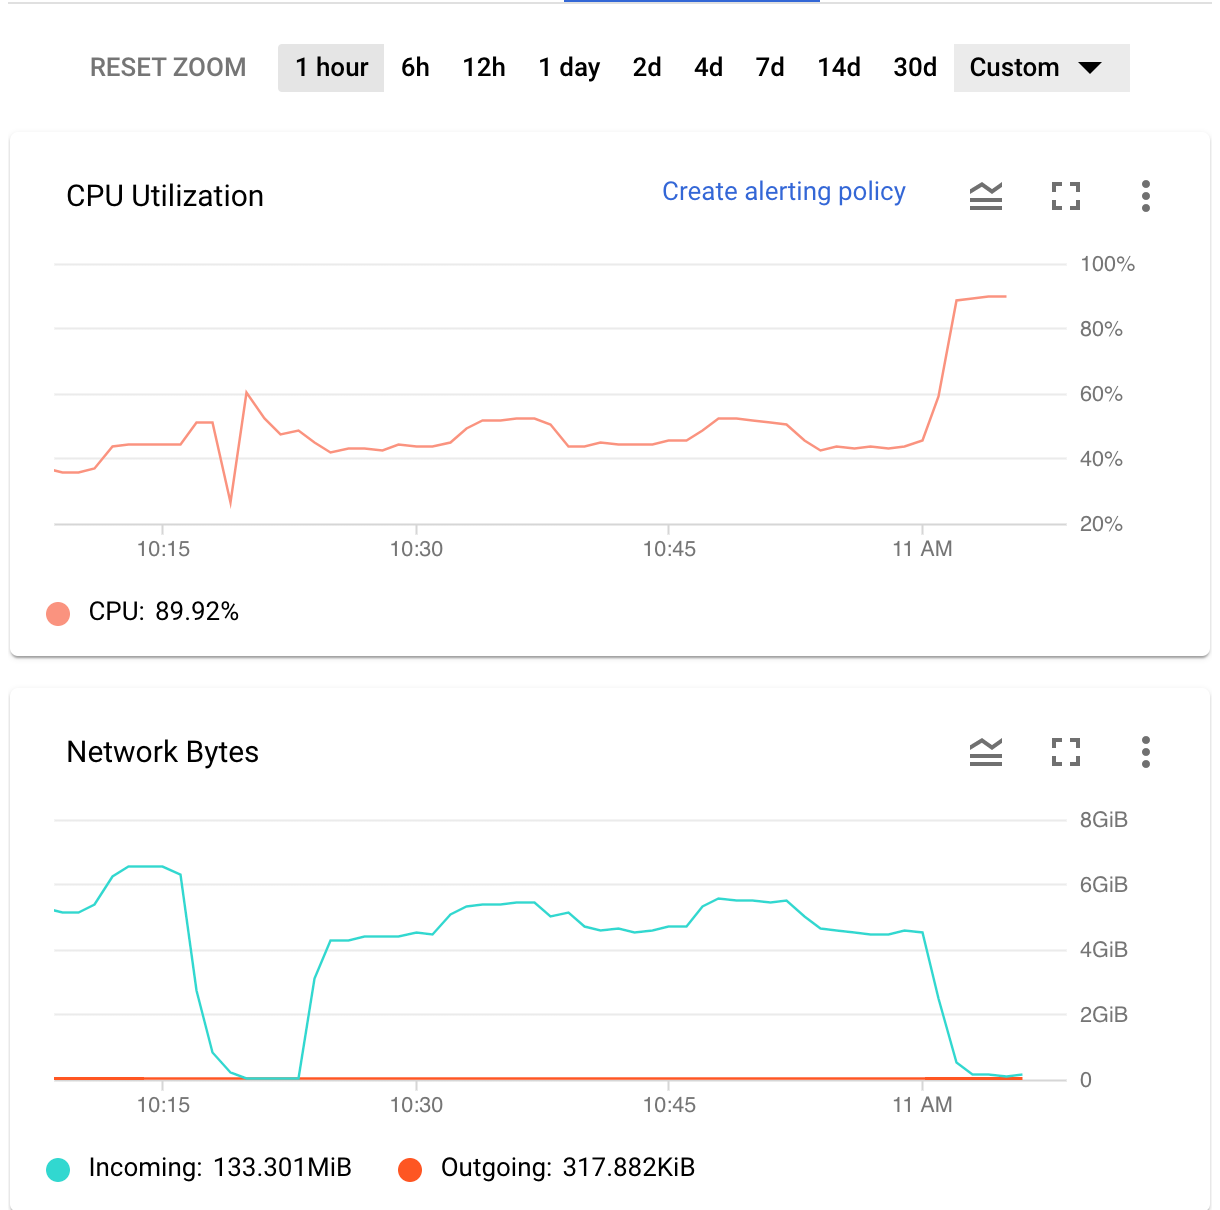